In [51]:
pip install pyMannKendall

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore


In [2]:
ASKA = pd.read_csv('ASKA_1991_2023_climvar_complete.txt', delimiter=r"\s+", header=1, 
                   names=['Date', 'Tmin', 'Tmax', 'Tmean', 'Rain', 'RH', 'UTCI', 'Humidex', 'HI'])

KINTAMPO = pd.read_csv('KINTAMPO_1991_2023_climvar_complete.txt', delimiter=r"\s+", header=1, 
                       names=['Date', 'Tmin', 'Tmax', 'Tmean', 'Rain', 'RH', 'UTCI', 'Humidex', 'HI'])

NAVRONGO = pd.read_csv('NAVRONGO_1991_2023_climvar_complete.txt', delimiter=r"\s+", header=1, 
                       names=['Date', 'Tmin', 'Tmax', 'Tmean', 'Rain', 'RH', 'UTCI', 'Humidex', 'HI'])

ASKA['Date'] = pd.to_datetime(ASKA['Date'], format='%d/%m/%Y', errors='coerce')
KINTAMPO['Date'] = pd.to_datetime(KINTAMPO['Date'], format='%d/%m/%Y', errors='coerce')
NAVRONGO['Date'] = pd.to_datetime(NAVRONGO['Date'], format='%d/%m/%Y', errors='coerce')

ASKA = ASKA.dropna(subset=['Date'])
KINTAMPO = KINTAMPO.dropna(subset=['Date'])
NAVRONGO = NAVRONGO.dropna(subset=['Date'])

ASKA.set_index('Date', inplace=True)
KINTAMPO.set_index('Date', inplace=True)
NAVRONGO.set_index('Date', inplace=True)


In [3]:
ASKA

,Tmin,Tmax,Tmean,Rain,RH,UTCI,Humidex,HI
Date,,,,,,,,
1991-01-02,18.81,29.96,24.38,0.0,45.48,26.62,35.08,30.33
1991-01-03,19.76,30.43,25.09,0.0,53.25,28.53,37.71,32.29
1991-01-04,20.71,31.59,26.15,0.0,57.39,29.76,40.81,35.42
1991-01-05,21.61,31.73,26.67,0.0,64.02,30.92,42.79,37.65
1991-01-06,23.21,32.03,27.62,0.0,75.08,30.58,46.29,42.43
...,...,...,...,...,...,...,...,...
2023-12-27,26.39,34.90,30.64,0.0,96.28,32.60,59.17,68.01
2023-12-28,26.16,33.49,29.83,0.0,91.44,32.52,54.13,56.80
2023-12-29,25.83,34.59,30.21,0.0,89.13,32.12,56.18,60.86


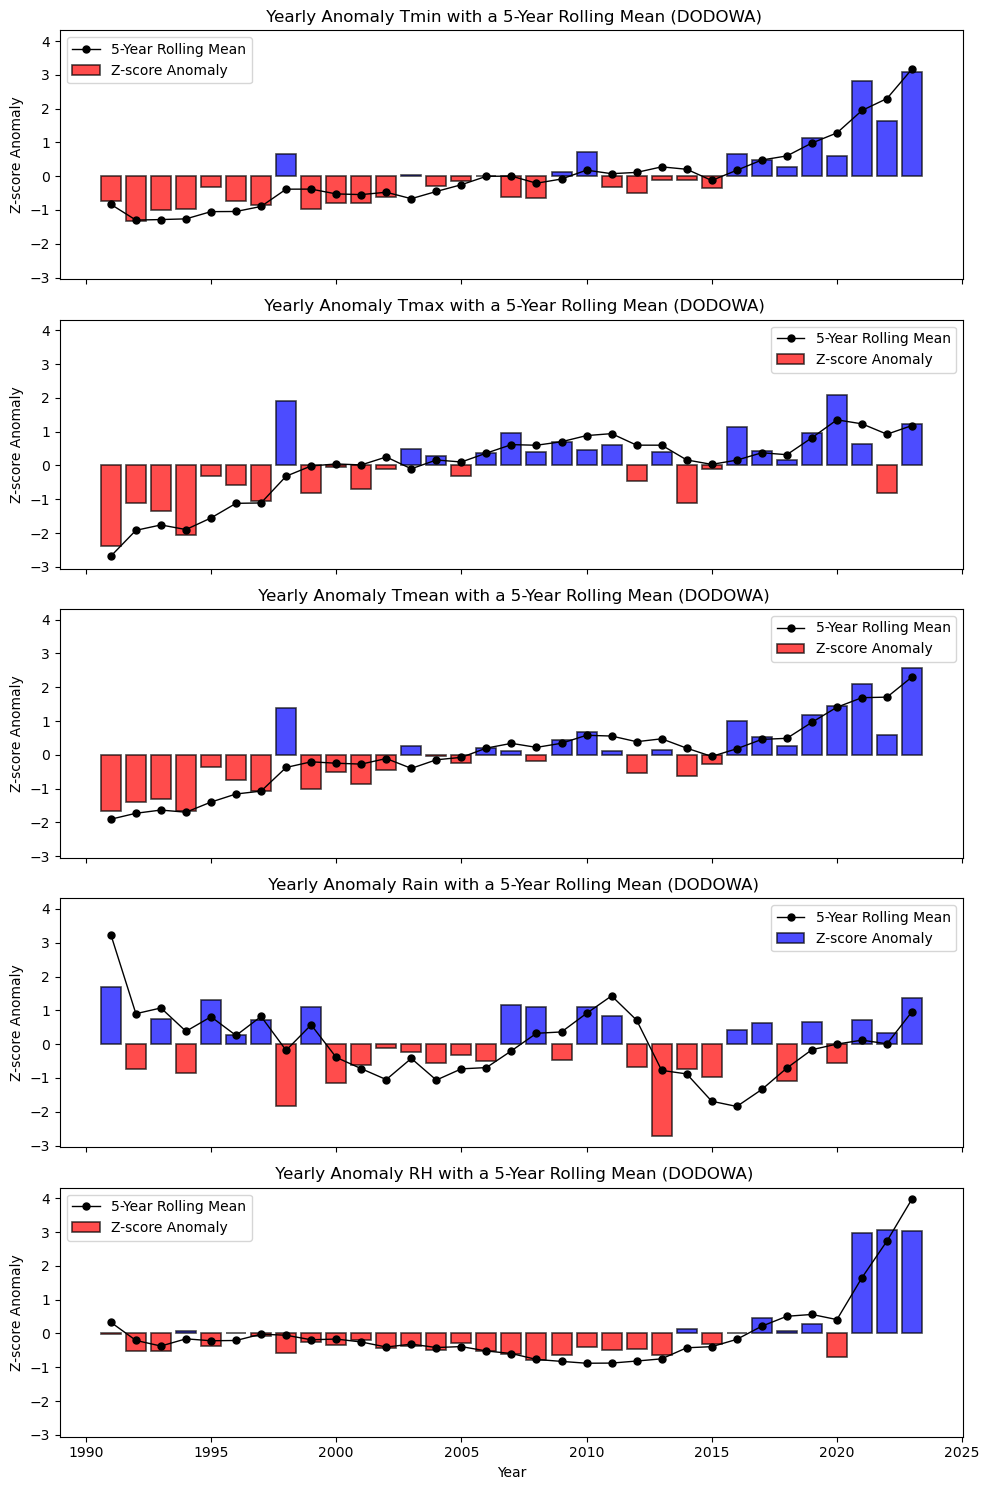

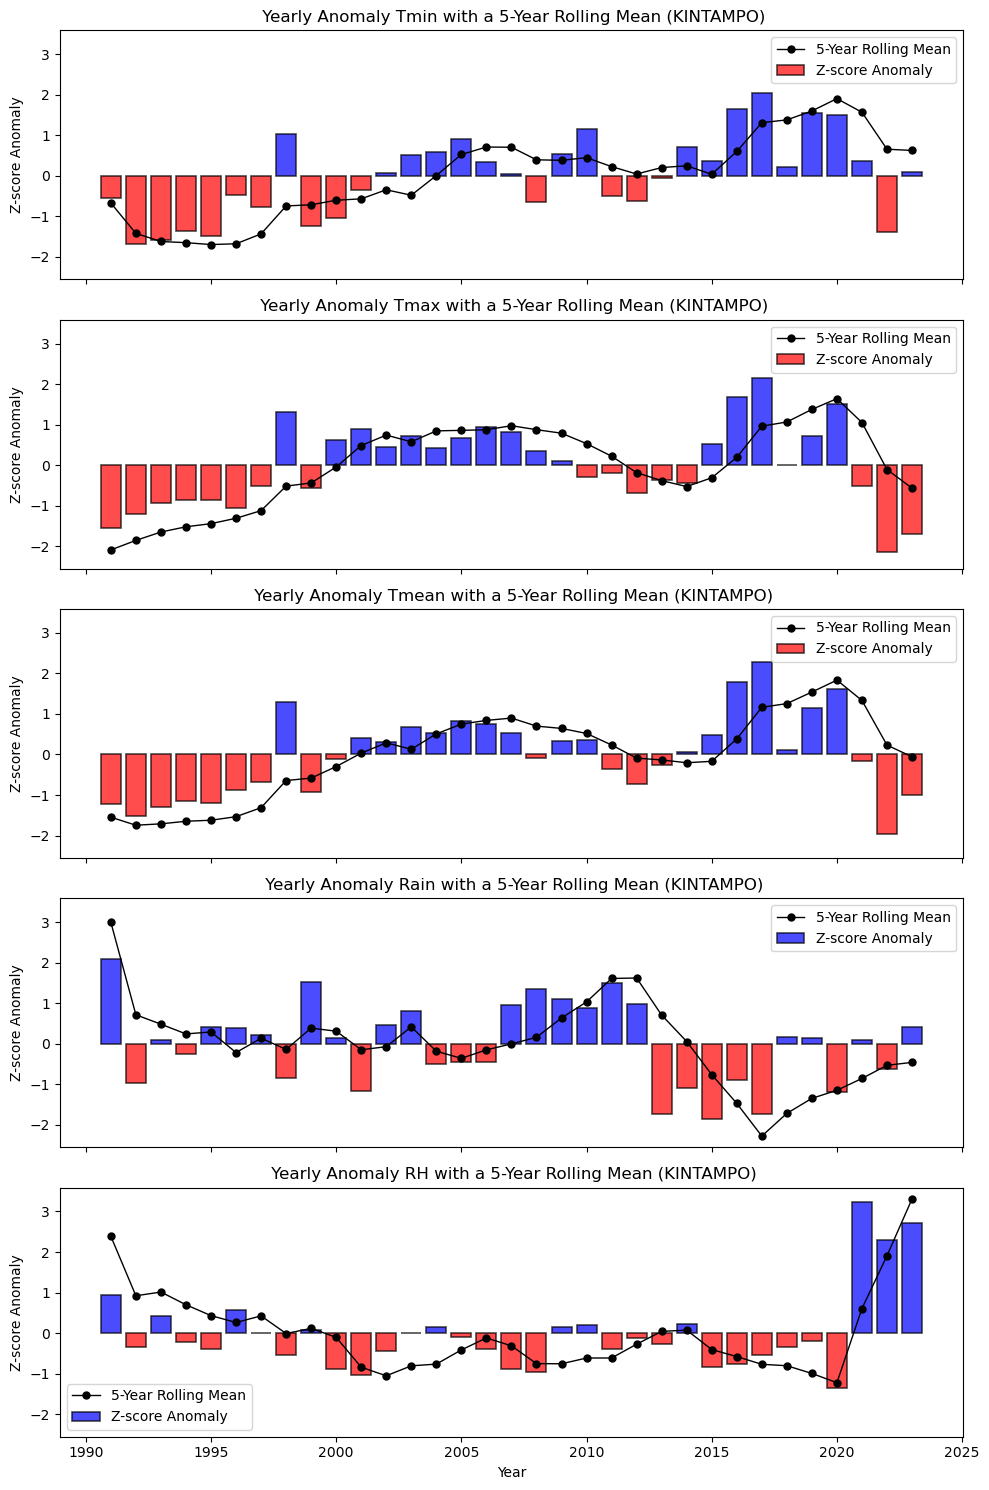

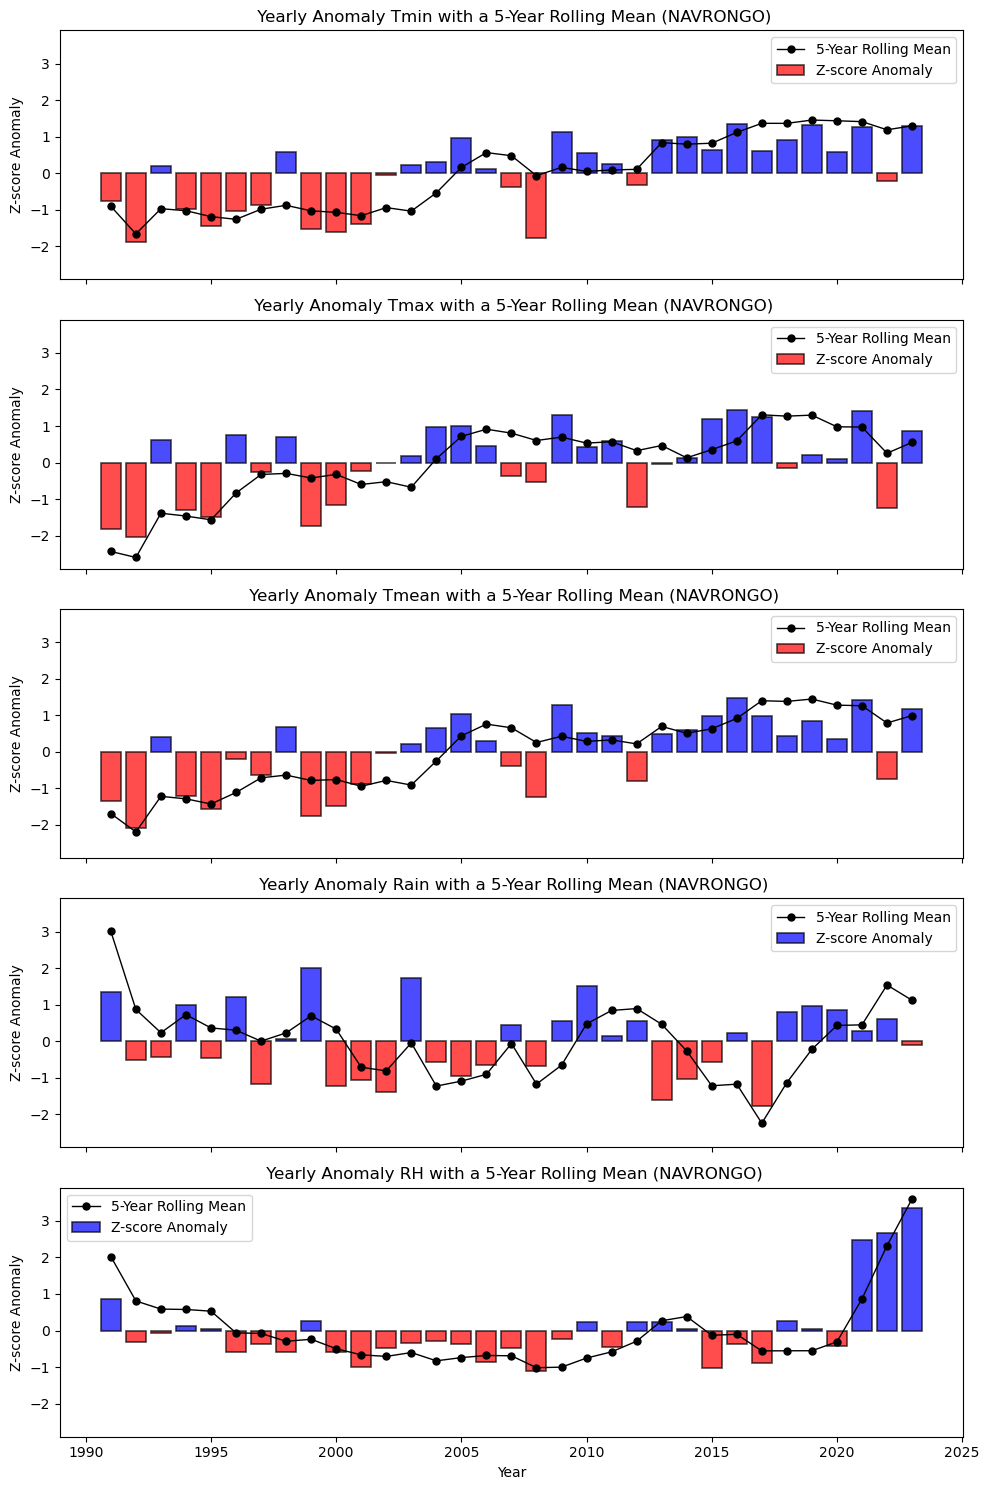

In [22]:

def calculate_yearly_anomalies(df, column):
    yearly_mean = df[column].resample('YE').mean()

    long_term_mean = yearly_mean.mean()
    return yearly_mean - long_term_mean

ASKA_yearly_anomalies = {col: calculate_yearly_anomalies(ASKA, col) for col in ['Tmin', 'Tmax', 'Tmean', 'Rain', 'RH']}
KINTAMPO_yearly_anomalies = {col: calculate_yearly_anomalies(KINTAMPO, col) for col in ['Tmin', 'Tmax', 'Tmean', 'Rain', 'RH']}
NAVRONGO_yearly_anomalies = {col: calculate_yearly_anomalies(NAVRONGO, col) for col in ['Tmin', 'Tmax', 'Tmean', 'Rain', 'RH']}

variables = ['Tmin', 'Tmax', 'Tmean', 'Rain', 'RH']

def plot_location_anomalies_with_rolling_mean(location, yearly_anomalies, filename):
    fig, axes = plt.subplots(5, 1, figsize=(10, 15), sharex=True, sharey=True)

    for i, variable in enumerate(variables):
        ax = axes[i]

        zscore_data = zscore(yearly_anomalies[variable])
        data_index = yearly_anomalies[variable].index.year
        color = ['blue' if z > 0 else 'red' for z in zscore_data]

        ax.bar(data_index, zscore_data, color=color, alpha=0.7, edgecolor='black', linewidth=1.2, label='Z-score Anomaly')

        rolling_mean = yearly_anomalies[variable].rolling(window=5, min_periods=1).mean()

        ax.plot(data_index, zscore(rolling_mean), color='black', label='5-Year Rolling Mean', linewidth=1,marker='o',markersize=5)

        ax.set_title(f' Yearly Anomaly {variable} with a 5-Year Rolling Mean ({location})')
        ax.set_ylabel('Z-score Anomaly')
        ax.legend()
    axes[-1].set_xlabel('Year')
    plt.tight_layout()

    plt.savefig(filename, format='jpeg', dpi=300)
    plt.show()

plot_location_anomalies_with_rolling_mean('DODOWA', ASKA_yearly_anomalies, 'ASKA_yearly_anomalies_with_rolling_mean.jpeg')
plot_location_anomalies_with_rolling_mean('KINTAMPO', KINTAMPO_yearly_anomalies, 'KINTAMPO_yearly_anomalies_with_rolling_mean.jpeg')
plot_location_anomalies_with_rolling_mean('NAVRONGO', NAVRONGO_yearly_anomalies, 'NAVRONGO_yearly_anomalies_with_rolling_mean.jpeg')


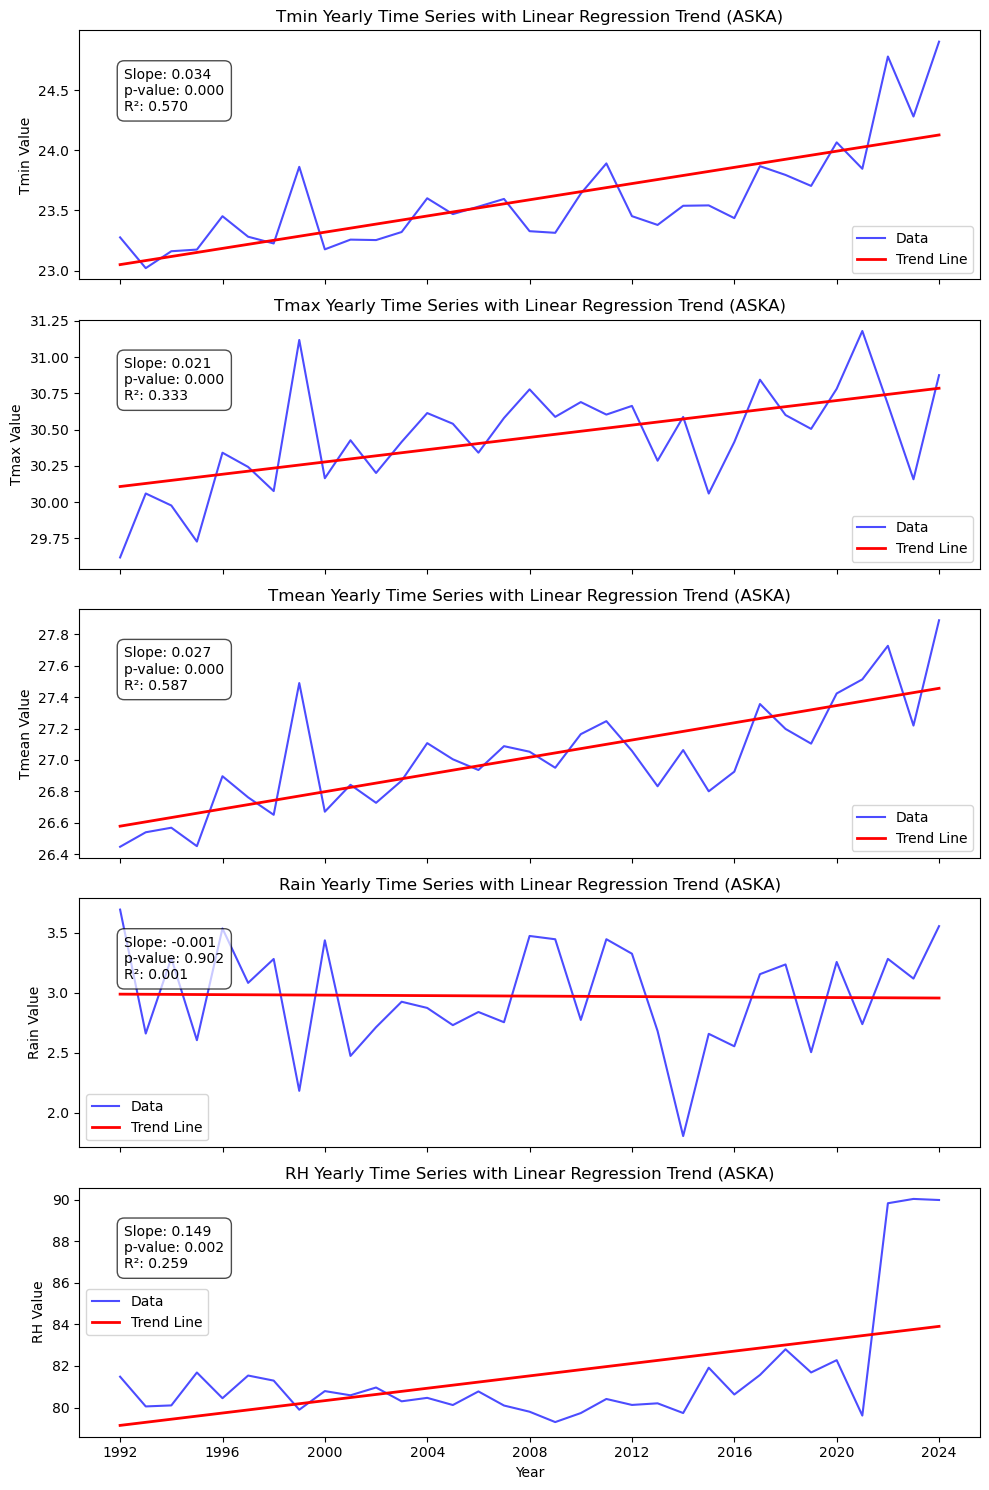

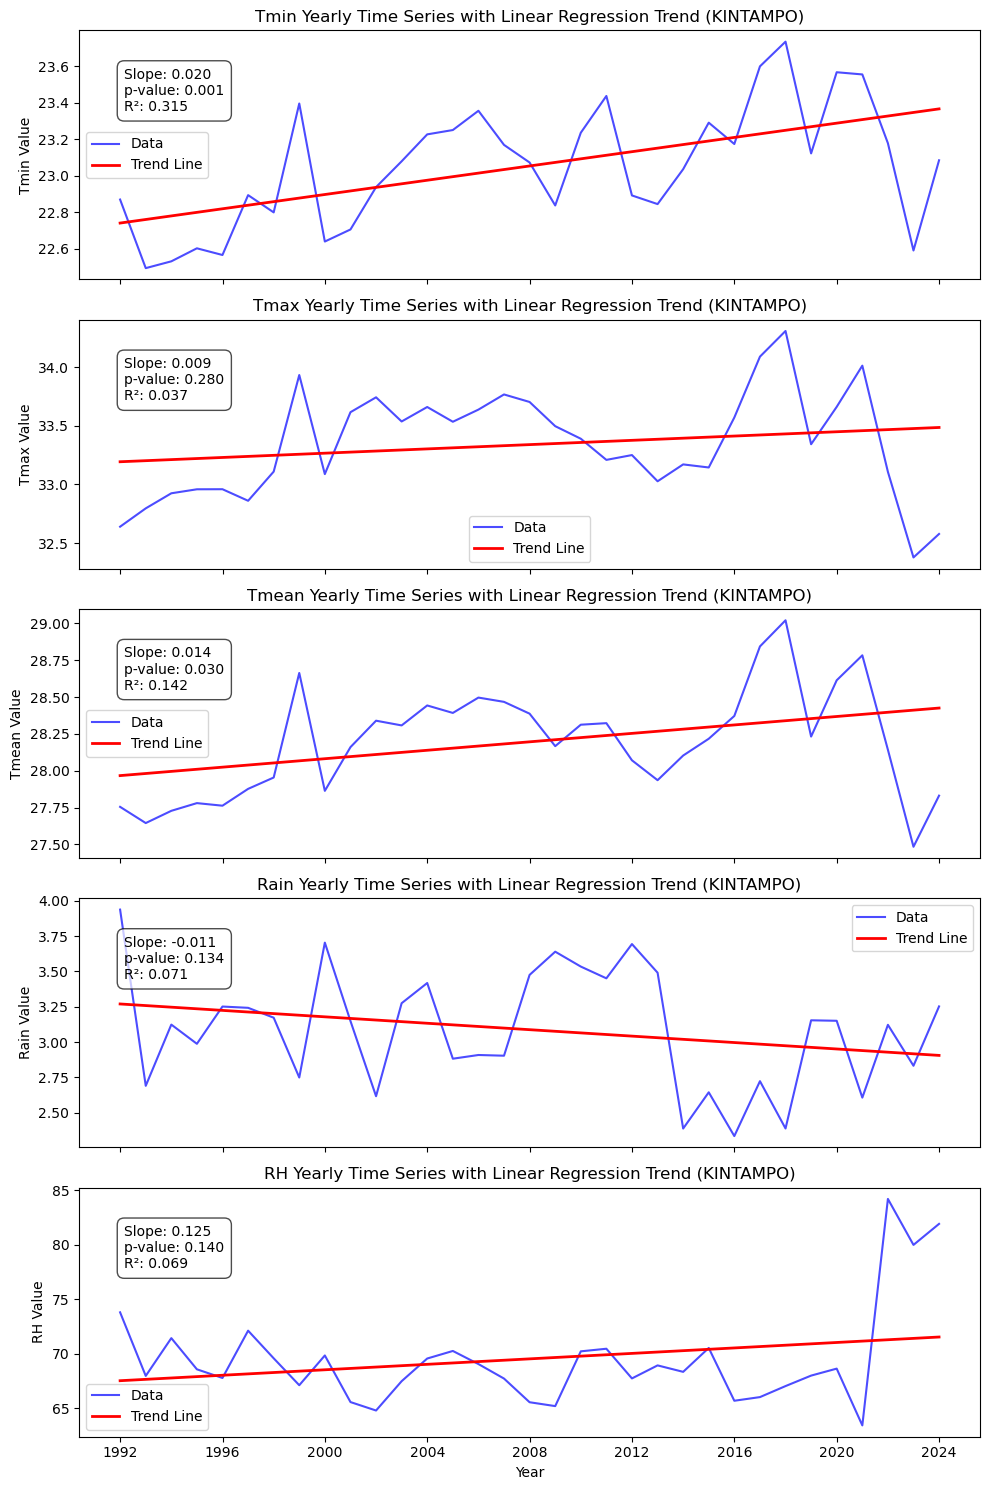

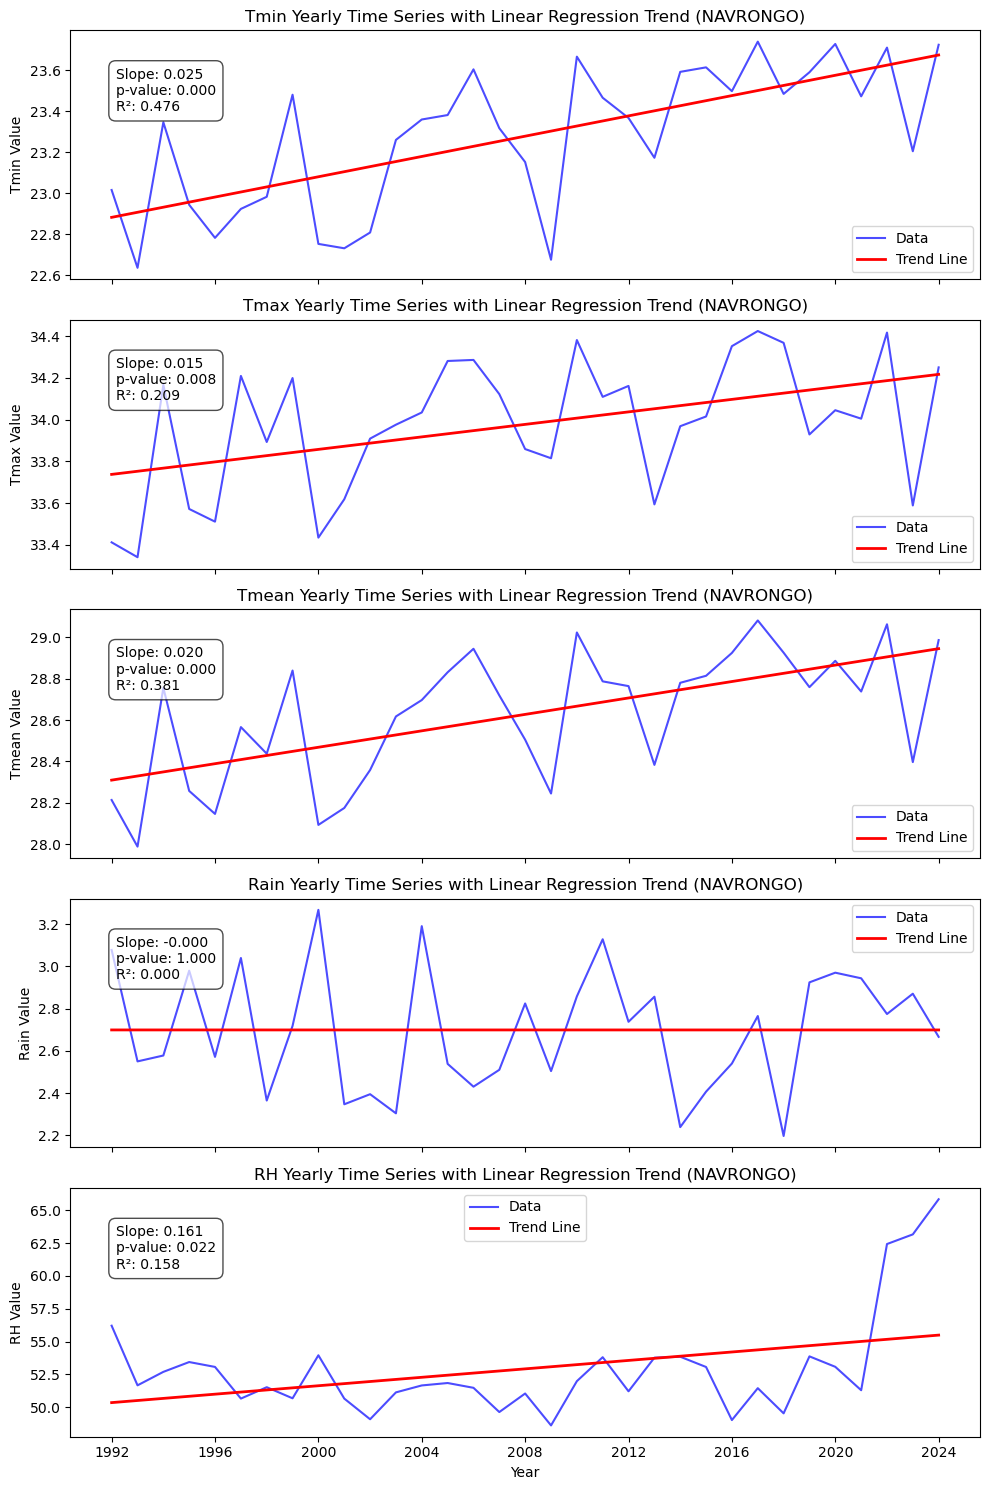

In [28]:

variables = ['Tmin', 'Tmax', 'Tmean', 'Rain', 'RH']
def plot_yearly_time_series_with_annotations_for_real_data(location, df, filename):

    df_yearly = df.resample('YE').mean()
    
    fig, axes = plt.subplots(5, 1, figsize=(10, 15), sharex=True, sharey=False)

    for i, variable in enumerate(variables):
        ax = axes[i]

        data = df_yearly[variable]
        years = data.index
        values = data.values

        slope, intercept, r_value, p_value, std_err = linregress(years.year, values)

        trend_line = slope * years.year + intercept
        ax.plot(years, values, color='blue', label='Data', alpha=0.7)
        ax.plot(years, trend_line, color='red', label='Trend Line', linewidth=2)

        annotation_text = f"Slope: {slope:.3f}\n"
        annotation_text += f"p-value: {p_value:.3f}\n"
        annotation_text += f"R²: {r_value**2:.3f}"

        ax.annotate(annotation_text, xy=(0.05, 0.85), xycoords='axes fraction', 
                    ha='left', va='top', fontsize=10, color='black', 
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round,pad=0.5'))

        ax.set_title(f'{variable} Yearly Time Series with Linear Regression Trend ({location})')
        ax.set_ylabel(f'{variable} Value')
        ax.legend()
    axes[-1].set_xlabel('Year')
    plt.tight_layout()

    plt.savefig(filename, format='jpeg', dpi=300)
    plt.show()

plot_yearly_time_series_with_annotations_for_real_data('ASKA', ASKA, 'ASKA_yearly_time_series_with_annotations_real_data.jpeg')
plot_yearly_time_series_with_annotations_for_real_data('KINTAMPO', KINTAMPO, 'KINTAMPO_yearly_time_series_with_annotations_real_data.jpeg')
plot_yearly_time_series_with_annotations_for_real_data('NAVRONGO', NAVRONGO, 'NAVRONGO_yearly_time_series_with_annotations_real_data.jpeg')
